### Install arcos4py from pypi

In [ ]:
! pip install arcos4py

### Import packages

In [1]:
import pandas as pd
from arcos4py import ARCOS
TAB20 = [
    "#1f77b4",
    "#aec7e8",
    "#ff7f0e",
    "#ffbb78",
    "#2ca02c",
    "#98df8a",
    "#d62728",
    "#ff9896",
    "#9467bd",
    "#c5b0d5",
    "#8c564b",
    "#c49c94",
    "#e377c2",
    "#f7b6d2",
    "#7f7f7f",
    "#c7c7c7",
    "#bcbd22",
    "#dbdb8d",
    "#17becf",
    "#9edae5",
]

### Example Dataset

The synthetic dataset contains 81 objects spaced on a 2D 9x9 lattice. Each object has an ID (column id) and can assume values 0 and 1 (column m), which correspond to an inactive and active state. The evolution of active states takes place over 8 consecutive time points (column t). Each cell moves slightly over time, hence a light wiggle around the initial position.

dataset location: arcos4py/sample_data/arcos_data.csv"

For an in-depth explanation of the parameters check out the documentation

### Set variables for loading and processing of the data

For an in-depth explanation of the parameters check out the documentation

In [2]:
# path to data
DATA: str = "sample_data/arcos_data.csv"

# column names in DATA
POSITION_COLUMN_NAMES: list = ['x', 'y']
FRAME_COLUMN_NAME: str = "t"
OBJECT_ID_COLUMN_NAME: str = 'id'
MEASUREMENT_COLUMN_NAME: str = "m"

# column name with collective event track ids
COLLID_COLUMN_NAME: str = "collid"

# values for clipping and interpolation
INTERPOLATE: bool = False
CLIP: bool = False
CLIP_LOW: float = 0.001
CLIP_HIGH: float = 0.999

# binarization parameters
DETRENDING_METHOD: str = "none"   # can be "none", "runmed" or "lm"
SMOOTHK: int = 3
BIASK: int = 25                     # needed only if BINARIZATION_METHOD method = runmed
PEAK_THRESHOLD: float = 0.5         # needed only if BINARIZATION_METHOD method = runmed
DEGREE_OF_POLYNOMIAL: int = 1       # needed only if BINARIZATION_METHOD method = lm
BINARIZATION_THRESHOLD: float = 0.5

# event detection parameters
EPS: float = 2
MIN_CLUSTER_SIZE: int = 2
NPREV_FRAMES: int = 1

# filter parameters
MIN_COLLECTIVE_EVENT_DURATION: int = 2
MIN_TOTAL_EVENT_SIZE: int = 5

### Load dataset

In [3]:
df = pd.read_csv(DATA)

# print first rows of data
df.head()

,t,x,y,m,id
0,1,0.228725,-0.158940,0,1
1,1,0.880323,-0.117712,0,2
2,1,1.930571,0.078604,0,3
3,1,2.958771,0.189801,0,4
4,1,3.902933,-0.041380,0,5


### Detect collective events

In [7]:
# create ARCOS object
ts = ARCOS(data=df, position_columns=POSITION_COLUMN_NAMES, frame_column=FRAME_COLUMN_NAME, obj_id_column=OBJECT_ID_COLUMN_NAME, measurement_column=MEASUREMENT_COLUMN_NAME, clid_column=COLLID_COLUMN_NAME)

# interpolate and clip if necessary
if INTERPOLATE:
    ts.interpolate_measurements() # interpolation of missing values, optional
if CLIP:
    ts.clip_measurements(CLIP_LOW, CLIP_HIGH) # clipping of measurement value, optional

# detrend and binarize data
ts.bin_measurements(smooth_k=SMOOTHK, bias_k=BIASK, peak_threshold=PEAK_THRESHOLD, binarization_threshold=BINARIZATION_THRESHOLD, polynomial_degree=DEGREE_OF_POLYNOMIAL, bias_method=DETRENDING_METHOD) # detrending and binarization

# detect and track collective events
collev = ts.track_collective_events(eps=EPS, min_clustersize=MIN_CLUSTER_SIZE, n_prev=NPREV_FRAMES)

# print first rows of detected collective events
collev.head()

  0%|          | 0/8 [00:00<?, ?it/s]

9it [00:00, 246.42it/s]              


,t,x,y,m,id,m.resc,m.bin,collid
0,3,3.890422,2.988866,1,32,1.0,1,1
1,3,3.086249,4.193937,1,40,1.0,1,1
2,3,3.997509,3.955390,1,41,1.0,1,1
3,3,5.060063,4.063136,1,42,1.0,1,1
4,3,3.837904,4.910511,1,50,1.0,1,1


## filter collective events

In [8]:
from arcos4py.tools import filterCollev

In [10]:
filterer = filterCollev(data = collev, frame_column= FRAME_COLUMN_NAME, clid_column=COLLID_COLUMN_NAME, obj_id_column=OBJECT_ID_COLUMN_NAME) # initialize class
collev_filtered = filterer.filter(min_duration=MIN_COLLECTIVE_EVENT_DURATION, min_total_size=MIN_TOTAL_EVENT_SIZE) #
collev_filtered.head()

,t,x,y,m,id,m.resc,m.bin,collid
0,3,3.890422,2.988866,1,32,1.0,1,1
1,3,3.086249,4.193937,1,40,1.0,1,1
2,3,3.997509,3.955390,1,41,1.0,1,1
3,3,5.060063,4.063136,1,42,1.0,1,1
4,3,3.837904,4.910511,1,50,1.0,1,1


### Collective event Stats

In [11]:
from arcos4py.tools import calcCollevStats

In [12]:
stats = calcCollevStats().calculate(collev_filtered, FRAME_COLUMN_NAME, COLLID_COLUMN_NAME, OBJECT_ID_COLUMN_NAME, POSITION_COLUMN_NAMES)
stats.head()

,collid,duration,first_timepoint,last_timepoint,total_size,min_size,max_size,first_frame_centroid_x,last_frame_centroid_x,first_frame_centroid_y,last_frame_centroid_y,centroid_speed,direction,first_frame_spatial_extent,first_frame_convex_hull_area,last_frame_spatial_extent,last_frame_convex_hull_area,size_variability
0,1,5,3,7,25,6,17,4.134267,3.58665,4.175573,4.009446,0.143065,-2.847052,2.213838,2.376217,5.400478,14.128779,5.718391


### Plotting Module

In [13]:
from arcos4py import plotting

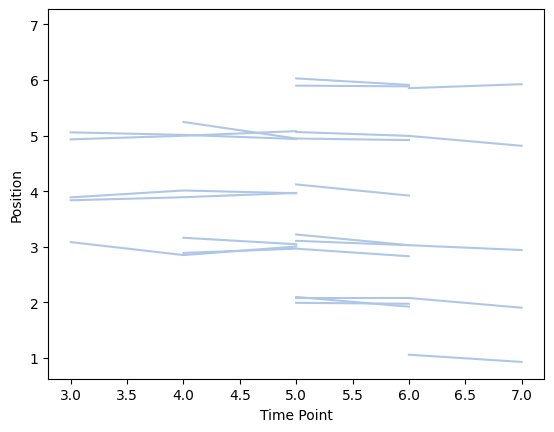

In [14]:
ndl = plotting.NoodlePlot(collev_filtered,COLLID_COLUMN_NAME, OBJECT_ID_COLUMN_NAME, FRAME_COLUMN_NAME, POSITION_COLUMN_NAMES[0], POSITION_COLUMN_NAMES[1])
ndl_plot = ndl.plot(POSITION_COLUMN_NAMES[0])

In [15]:
data_plots = plotting.dataPlots(df,FRAME_COLUMN_NAME, MEASUREMENT_COLUMN_NAME, OBJECT_ID_COLUMN_NAME)

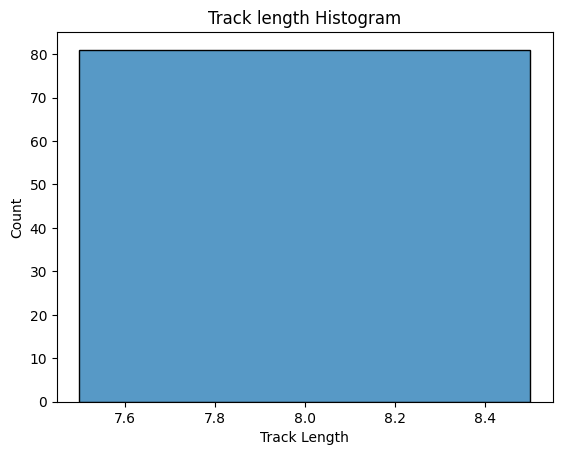

In [16]:
hist = data_plots.histogram()

C:\Users\benig\Documents\python_dev\arcos4py\arcos4py\plotting\_plotting.py:165: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  plot = sns.displot(


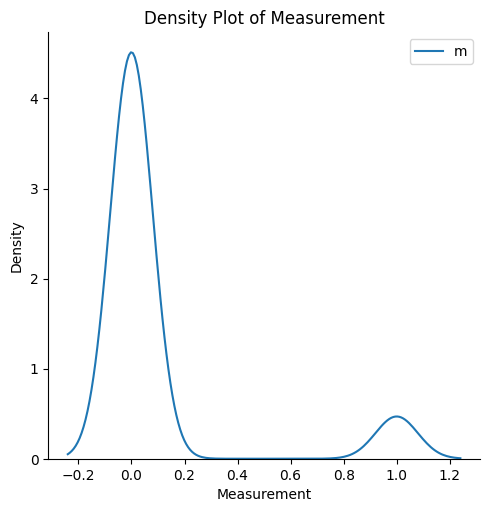

In [17]:
dens = data_plots.density_plot()

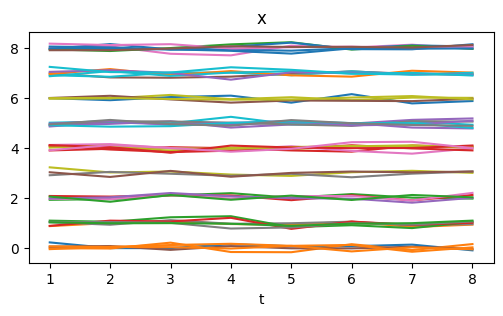

In [18]:
xt_plot = data_plots.position_t_plot({POSITION_COLUMN_NAMES[0]}, n=50)

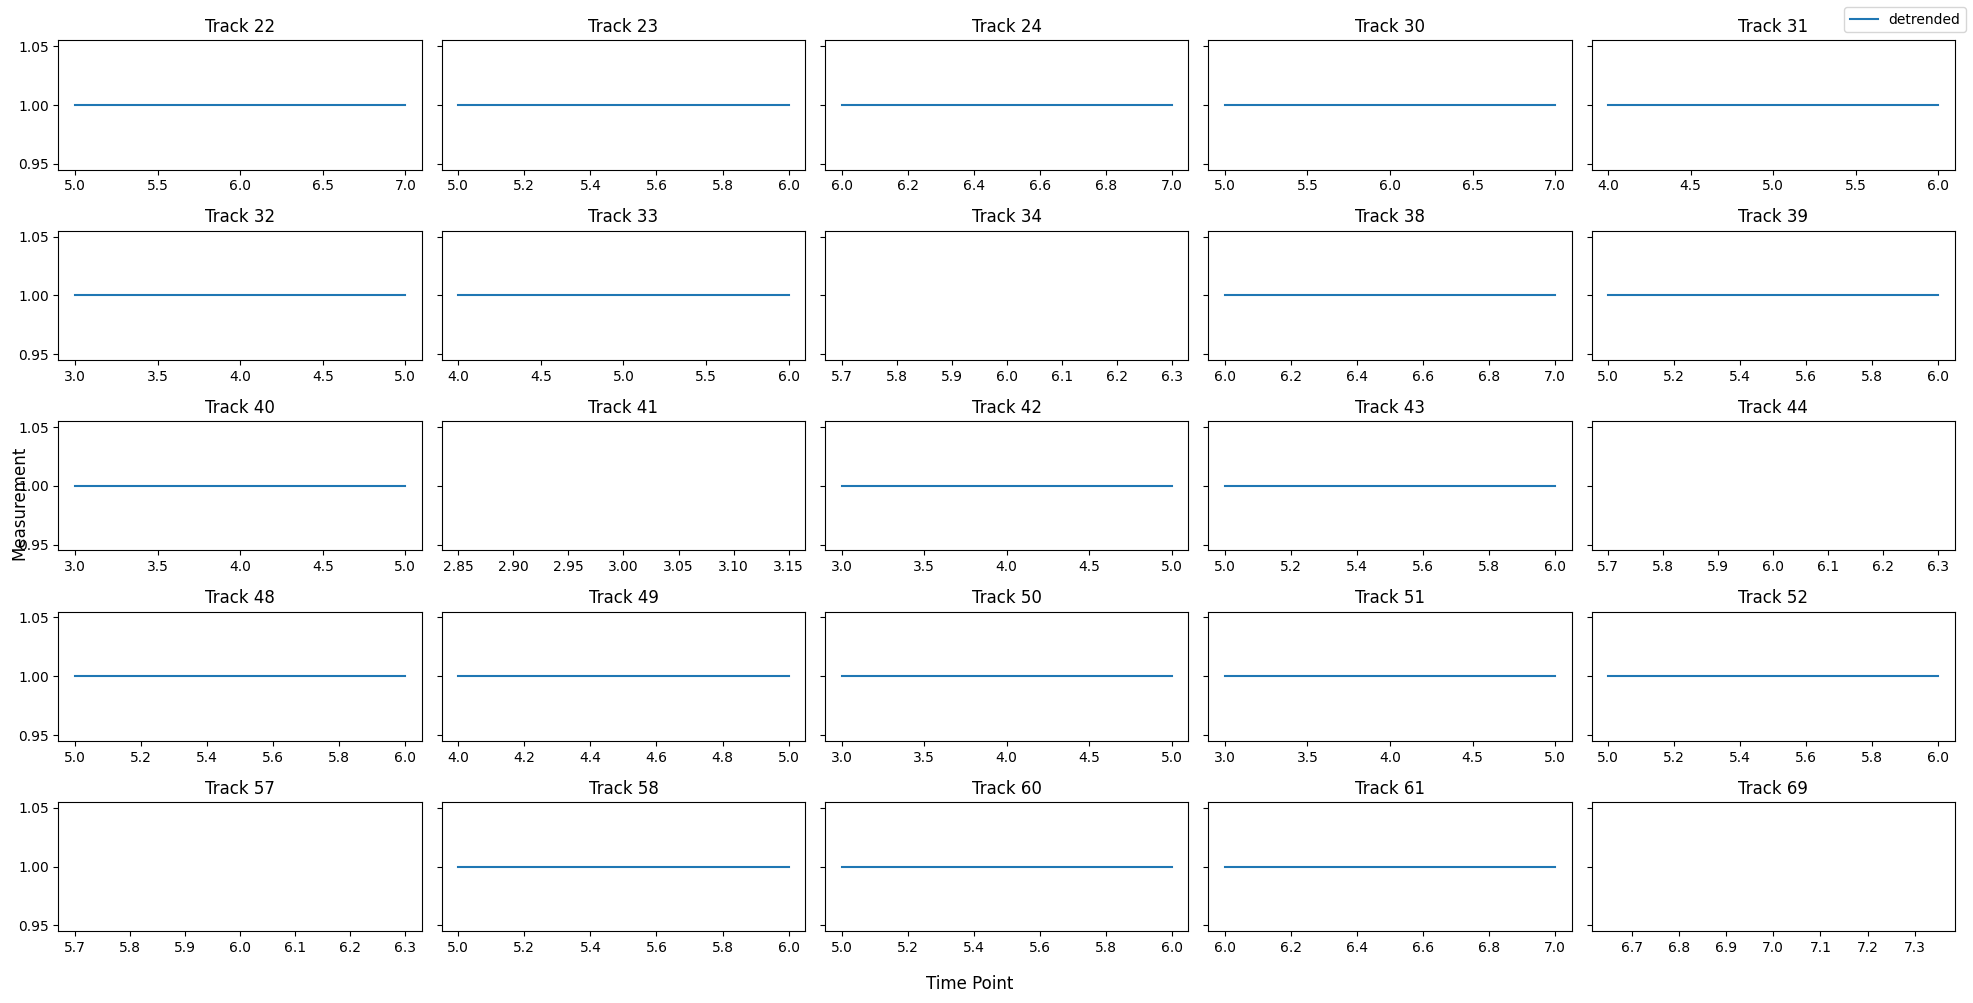

In [19]:
detrend_plot = plotting.plotOriginalDetrended(collev,FRAME_COLUMN_NAME, MEASUREMENT_COLUMN_NAME,f'{MEASUREMENT_COLUMN_NAME}.resc',OBJECT_ID_COLUMN_NAME).plot_detrended()

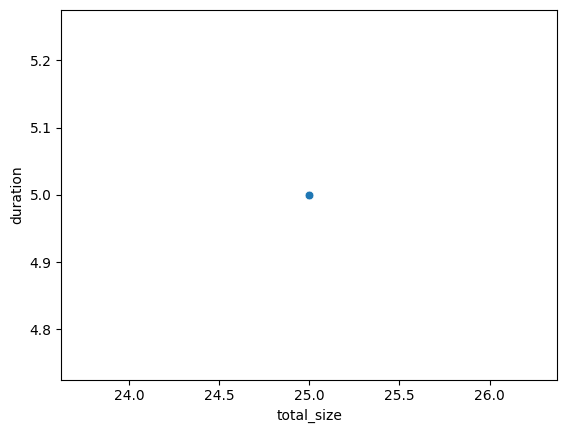

In [20]:
coll_dur_size_scatter = plotting.statsPlots(stats).plot_events_duration('total_size','duration')